In [2]:
import numpy as np

from graphs import complete_graph, gnp_graph, barabasi_albert_graph
from util import convergence_time, run_sharing_experiment, run_following_experiment
from evolve import run_evolving_experiment
from visualize import plot_graph

In [49]:
def sharing_convergence():
    """
    Dependent variables: 
        1) average stance in convergence
        2) rounds (time steps) before convergence
    Independent variables:
        1) graph structure, size, and average degree
        2) impressionability (beta parameter)
    Controlling:
        1) truthful sharing 
    """
    ### game parameters
    # graph
    n_list = [100,500,1000]
    avg_degree_list = [10,50,100]
    
    # personalities
    beta_list = list(np.hstack((np.arange(0, 1, 0.1), np.array([1]))))   

    # fixed experiment parameters
    convergence_eps = 0.01
    T = 30
    strategies = 'truthful'
    n_trials = 30
    n_topologies = 3

    ### results
    convergence_time = np.empty((len(n_list), len(beta_list), n_topologies, n_trials))
    avg_stance_complete = np.empty((len(n_list), len(beta_list), n_topologies, n_trials))

    ### simulate
    for n_idx, n in enumerate(n_list):
        alphas, gammas = [-1.0] * n, [lambda R: 0.0 * R] * n
        for d_idx, d in enumerate(avg_degree_list):
            for b_idx, b in enumerate(beta_list):
                for t_idx in range(n_trials):
                    # generate instances
                    init_stances = np.random.uniform(low=-1, high=1, size=n)
                    betas = [b] * n

                    E_mat_complete = complete_graph(n)
                    E_mat_gnp = gnp_graph(n, d)
                    E_mat_ba = barabasi_albert_graph(n, d)
                    
                    graphs_list = [E_mat_complete, E_mat_gnp, E_mat_ba]
                    for g_idx, graph in enumerate(graphs_list):
                        stances, _, _ = run_sharing_experiment(init_stances, alphas, betas, gammas, 
                                                                             strategies, T, graph)
                        convergence_time[n_idx, d_idx, b_idx, g_idx, t_idx] = convergence_time(stances, 
                                                                                               convergence_eps)
                        avg_stance[n_idx, d_idx, b_idx, g_idx, t_idx] = np.mean(stances[-1])

    return avg_stance, convergence_time

In [15]:
def sharing_optimality():
    """
    Dependent variables: 
        1) utility
    Independent variables:
        1) sharing strategy
    Controlling:
        1) personalities (alpha, beta, gamma)
        2) graph structure, size, and average degree
    """
    ### game parameters
    # graph
    n_list = [100,]
    avg_degree_list = [10,50]
    
    # personalities
    a = -1
    b = 0.5
    g = 1
    
    # strategies
    strategies_list = ['truthful', 'extreme']
    
    # fixed experiment parameters
    n_trials = 30
    T = 30
    n_topologies = 3
    
    ### results
    avg_utilities = np.empty((len(n_list), len(avg_degree_list), n_topologies, len(strategies_list), n_trials))

    ### simulate
    for n_idx, n in enumerate(n_list):
        alphas, betas, gammas = [a] * n, [b] * n, [lambda R: g * R] * n
        for d_idx, d in enumerate(avg_degree_list):    
            for t_idx in range(n_trials): 
                # generate graph instances
                init_stances = np.random.uniform(low=-1, high=1, size=n)
                E_mat_complete = complete_graph(n)
                E_mat_gnp = gnp_graph(n, d)
                E_mat_ba = barabasi_albert_graph(n, d)
                graph_list = [E_mat_complete, E_mat_gnp, E_mat_ba]

                for g_idx, graph in enumerate(graph_list):
                    for strategy_idx, strategy in enumerate(strategies_list):
                        # try all strategies
                        stances, actions, utilities = run_sharing_experiment(init_stances, alphas, betas, gammas, 
                                                                             strategy, T, graph)
                        avg_utilities[n_idx, d_idx, g_idx, strategy_idx, t_idx] = np.mean(utilities)

    return avg_utilities

In [5]:
def sharing_evolution():
    """
    Formulate a linear sharing strategy as
        s = diff_mult * (average stance difference) + stance_mult * current stance
        
    Run sequential sharing games. Proceed as follows.
        1) In the first round t=1, uniformly initialize values of diff_mult and stance_mult.
        2) In subsequent rounds t>1, agents in round t-1 birth new agents proportional to their utility in round t-1.
        3) Repeat the sharing and birthing process.
        
    Controlling:
        1) personalities (alpha, beta, gamma)
        2) graph structure, size, and average degree
    """
    ### game parameters
    # graph
    n_list = [100]
    avg_degree_list = [10]
    
    # personalities
    a = -1
    b = 0.5
    g = 1
    
    # fixed experiment parameters
    T = 30
    n_rounds = 3
    n_trials = 2
    n_topologies = 3
    
    ### results
    avg_utilities = np.empty((len(n_list), len(avg_degree_list), n_topologies, n_trials))
    stance_mults = np.empty((len(n_list), len(avg_degree_list), n_topologies, n_trials, max(n_list)))
    diff_mults = np.empty((len(n_list), len(avg_degree_list), n_topologies, n_trials, max(n_list)))

    ### simulate
    for n_idx, n in enumerate(n_list):
        alphas, betas, gammas = [a] * n, [b] * n, [lambda R: g * R] * n
        for d_idx, d in enumerate(avg_degree_list):            
            for t_idx in range(n_trials): 
                # generate graph instances
                init_stances = np.random.uniform(low=-1, high=1, size=n)
                E_mat_complete = complete_graph(n)
                E_mat_gnp = gnp_graph(n, d)
                E_mat_ba = barabasi_albert_graph(n, d)
                graph_list = [E_mat_complete, E_mat_gnp, E_mat_ba]

                for g_idx, graph in enumerate(graph_list):
                    utilities, stance_mult, diff_mult = run_evolving_experiment(init_stances, alphas, betas, gammas, 
                                                                                'linear', T, graph, n_rounds, 
                                                                                initialization='uniform', 
                                                                                mutation_rate=0.05)
                    
                    avg_utilities[n_idx, d_idx, g_idx, t_idx] = np.mean(utilities)
                    padding = (0, stance_mults.shape[-1] - stance_mult.shape[0])
                    stance_mults[n_idx, d_idx, g_idx, t_idx] = np.lib.pad(stance_mult, padding, 'constant', 
                                                                          constant_values=np.NAN)
                    diff_mults[n_idx, d_idx, g_idx, t_idx] = np.lib.pad(diff_mult, padding, 'constant', 
                                                                        constant_values=np.NAN)
                     
    return avg_utilities, stance_mults, diff_mults

In [3]:
def following_convergence():
    """
    Dependent variables: 
        1) long-run graph structure
        2) stances
    Independent variables:
        1) initial opinions, graph structure, size, and average degree
            Initial structures:
                a) Complete
                b) Complete connected components
                c) E-R
                d) B-A
            Initial opinions:
                a) Extremes
                b) Uniform
    Controlling:
        1) personalities (alpha, beta, gamma)
        2) approximately optimal sharing strategies
    """
    ### game parameters
    # graph
    n = 8
    avg_degree = 5
    
    # personalities
    a = -1
    b = 0.01
    g = 0.15
    alphas, betas, gammas = [a] * n, [b] * n, [lambda R: g * R] * n
    
    # fixed experiment parameters
    T = 30
    n_trials = 4
    n_topologies = 4
    n_init_stances = 2
    
    ### results
    Gs = np.empty((n_topologies, n_init_stances, n_trials, n, n))
    final_stances = np.empty((n_topologies, n_init_stances, n_trials, n))
    
    ### simulate           
    for t_idx in range(n_trials): 
        ## generate graph instances
        # complete graph
        E_mat_complete = complete_graph(n)
        
        # completely connected components
        assert(n % 2 == 0)
        half_n = n / 2
        ones_quadrant = np.ones((half_n, half_n))
        zeros_quadrant = np.zeros((half_n, half_n))
        upper = np.hstack((ones_quadrant, zeros_quadrant))
        lower = np.hstack((zeros_quadrant, ones_quadrant))
        E_mat_CC = np.vstack((upper, lower))
        np.fill_diagonal(E_mat_CC, 0)
        
        # G(n,p)
        E_mat_gnp = gnp_graph(n, avg_degree)
        
        # Barabsi-Albert
        E_mat_ba = barabasi_albert_graph(n, avg_degree)
        
        ## initial stances
        # uniform
        init_stances_unif = np.random.uniform(low=-1, high=1, size=n)
        
        # random extreme: half -1s, half 1s
        ordered = np.hstack((np.ones(half_n), -np.ones(n - half_n)))
        init_stances_extreme = np.random.permutation(ordered)
        
        graph_list = [E_mat_complete, E_mat_CC, E_mat_gnp, E_mat_ba]
        stances_list = [init_stances_unif, init_stances_extreme]
        
        # run for each set of initial conditions
        for g_idx, graph in enumerate(graph_list):
            for s_idx, init_stances in enumerate(stances_list):
                stances, G, _ = run_following_experiment(init_stances, alphas, betas, gammas, 'approx_opt', T, graph,
                                                         calc_utilities=False, keep_G=False)

                Gs[g_idx, s_idx, t_idx] = G
                final_stances[g_idx, s_idx, t_idx] = stances[-1]
                
        # check stability of party system
        stable_gammas = [lambda R: 0.0 * R] * n
        stances, G, _ = run_following_experiment(ordered, alphas, betas, stable_gammas, 'approx_opt', T, E_mat_CC, 
                                                 calc_utilities=False, keep_G=False)
        G[np.isnan(G)] = 0
        assert(np.array_equal(G, E_mat_CC))
        assert(np.array_equal(stances[-1], ordered))

    return Gs, final_stances

In [5]:
stances, convergence_time = sharing_convergence()

avg_stances = np.mean(stances, axis=-1)
avg_convergence_time = np.mean(convergence_time, axis=-1)

print "complete", avg_stances[0]
print "complete", avg_convergence_time[0]

print "gnp", avg_stances[1]        
print "gnp", avg_convergence_time[1]

print "ba", avg_stances[2]
print "ba", avg_convergence_time[2]


n, d, b, t 100 10 0.0 0
n, d, b, t 100 10 0.0 1
n, d, b, t 100 10 0.0 2
n, d, b, t 100 10 0.0 3
n, d, b, t 100 10 0.0 4
n, d, b, t 100 10 0.0 5
n, d, b, t 100 10 0.0 6
n, d, b, t 100 10 0.0 7
n, d, b, t 100 10 0.0 8
n, d, b, t 100 10 0.0 9
n, d, b, t 100 10 0.0 10
n, d, b, t 100 10 0.0 11
n, d, b, t 100 10 0.0 12
n, d, b, t 100 10 0.0 13
n, d, b, t 100 10 0.0 14
n, d, b, t 100 10 0.0 15
n, d, b, t 100 10 0.0 16
n, d, b, t 100 10 0.0 17
n, d, b, t 100 10 0.0 18
n, d, b, t 100 10 0.0 19
n, d, b, t 100 10 0.0 20
n, d, b, t 100 10 0.0 21
n, d, b, t 100 10 0.0 22
n, d, b, t 100 10 0.0 23
n, d, b, t 100 10 0.0 24
n, d, b, t 100 10 0.0 25
n, d, b, t 100 10 0.0 26
n, d, b, t 100 10 0.0 27
n, d, b, t 100 10 0.0 28
n, d, b, t 100 10 0.0 29
n, d, b, t 100 10 0.1 0
n, d, b, t 100 10 0.1 1
n, d, b, t 100 10 0.1 2
n, d, b, t 100 10 0.1 3
n, d, b, t 100 10 0.1 4
n, d, b, t 100 10 0.1 5
n, d, b, t 100 10 0.1 6
n, d, b, t 100 10 0.1 7
n, d, b, t 100 10 0.1 8
n, d, b, t 100 10 0.1 9
n, d, b, t 100 10 0.

In [16]:
avg_utilities = sharing_optimality()

In [6]:
avg_utilities, stance_mults, diff_mults = sharing_evolution()

In [4]:
Gs, stances = following_convergence()

In [9]:
p, g, s = plot_graph(Gs[1,0,0], stances=stances[1,0,0], actions=stances[1,0,0], scale_nodes="outdegree", margin=40, file_name="example")

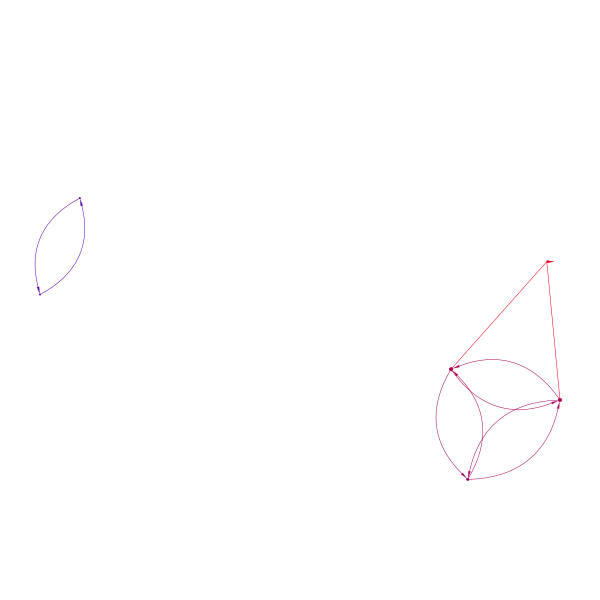

In [10]:
p

In [5]:
stances[0,0,0]

array([-0.96410073, -0.6250434 , -0.68073721,  0.19545004,  0.71978863,
        0.88230306, -0.62506406,  0.77042896])

In [13]:
Gs[3,1]

array([[[ nan,  nan,   1.,  nan,  nan,   1.,  nan,   1.],
        [ nan,  nan,  nan,   1.,   1.,  nan,   1.,  nan],
        [  1.,  nan,  nan,  nan,  nan,   1.,  nan,   1.],
        [ nan,   1.,  nan,  nan,   1.,  nan,   1.,  nan],
        [ nan,   1.,  nan,   1.,  nan,  nan,   1.,  nan],
        [  1.,  nan,   1.,  nan,  nan,  nan,  nan,   1.],
        [ nan,   1.,  nan,   1.,   1.,  nan,  nan,  nan],
        [  1.,  nan,   1.,  nan,  nan,   1.,  nan,  nan]],

       [[ nan,   1.,  nan,  nan,  nan,  nan,   1.,   1.],
        [  1.,  nan,  nan,  nan,  nan,  nan,   1.,   1.],
        [ nan,  nan,  nan,   1.,   1.,   1.,  nan,  nan],
        [ nan,  nan,   1.,  nan,   1.,   1.,  nan,  nan],
        [ nan,  nan,   1.,   1.,  nan,   1.,  nan,  nan],
        [ nan,  nan,   1.,   1.,   1.,  nan,  nan,  nan],
        [  1.,   1.,  nan,  nan,  nan,  nan,  nan,   1.],
        [  1.,   1.,  nan,  nan,  nan,  nan,   1.,  nan]],

       [[ nan,  nan,   1.,   1.,  nan,   1.,  nan,  nan],
        [ 